## Problem Statement:

Various features are provided which may be the cause of a heart attack among patients. A  classification model is required to classify whether a patient may or may not suffer from a heart attack with respect to his/her conditions given in the form of features. 

#### Independent Variables :

1.Age : Age of the patient

2.Sex : Sex of the patient (1=Male,0=Female)

3.exang: exercise induced angina (1 = yes; 0 = no)

4.ca: number of major vessels (0-3)

5.cp : Chest Pain type 

Value 1: typical angina
Value 2: atypical angina
Value 3: non-anginal pain
Value 4: asymptomatic

6.trtbps : resting blood pressure (in mm Hg)

7.chol : cholestoral in mg/dl fetched via BMI sensor

8.fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

9.rest_ecg : resting electrocardiographic results

Value 0: normal
Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

10.slp: The slope of the peak exercise ST segment

11.oldpeak: ST depression induced by exercise relative to rest

12.thalach : maximum heart rate achieved

13.thal : Thal rate

#### Depenedent/Target Varibale :

14.output : 0= less chance of heart attack 1= more chance of heart attack

## Importing Required Libraries :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
plt.style.use('seaborn-pastel')
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,roc_curve
from sklearn.linear_model import LogisticRegression
from statsmodels.api import Logit
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,StackingClassifier
from xgboost import XGBClassifier

In [2]:
df_heart=pd.read_csv('heart.csv')
# First 5 values
df_heart.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df_heart.shape

(303, 14)

###### Inference: There are 303 rows and 14 columns in the dataset.

## Null Value Treatment :

In [4]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


###### Inference: As per the info() function there are no null values present in the dataset. Also the datatypes of each of the variables can be analysed.

## Exploratory Data Analysis :

In [5]:
#Separating numerical and categorical variables.
df_cat=df_heart.iloc[:,[1,2,5,6,8,10,11,12,13]]
df_cat.head(2)

,sex,cp,fbs,restecg,exng,slp,caa,thall,output
0,1,3,1,0,0,0,0,1,1
1,1,2,0,1,0,0,0,2,1


In [6]:
df_num=df_heart.iloc[:,[0,3,4,7,9]]
df_num.head(2)

,age,trtbps,chol,thalachh,oldpeak
0,63,145,233,150,2.3
1,37,130,250,187,3.5


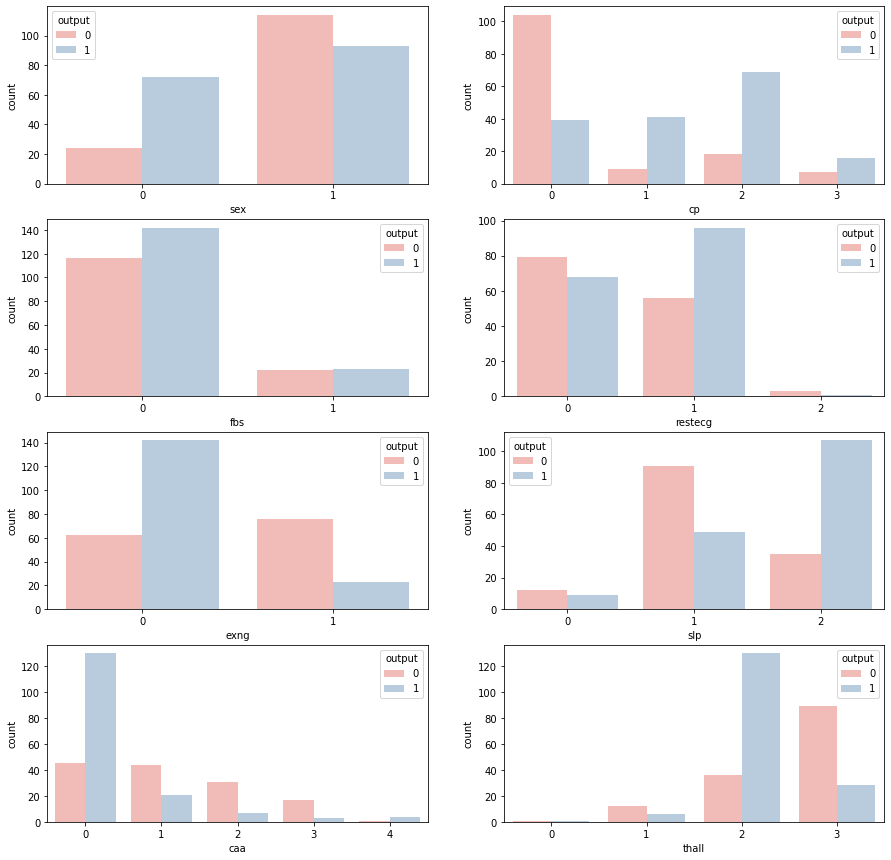

In [7]:
# Categorical variables with respect to target variables
fig,ax=plt.subplots(4,2,figsize=(15,15))

for col,ax in zip(df_cat.columns[:-1],ax.flatten()):
    x=sns.countplot(df_cat[col],ax=ax ,hue=df_cat['output'],palette='Pastel1')

##### Inference:
##### 1.As per the plots above , more males are prone to suffer from a heart attack than females
##### 2. Most people having a typical anginal pain (0) dont get a heart attack where as  most people with non-anginal pain (2) end get a heart attack
##### 3. Most people with fasting blood sugar >120 mg/dl (0) suffer from a heart attack
##### 4. Resting electrocardiographic results having ST-T wave abnormality (1) are highly prone to suffer from a heart attack.
##### 5. Most people do not get a heart attack after an exercise induced angina.
##### 6. The slope of the peak exercise ST segment shows that type 2 has the highest number of people getting a heart attack.
##### 7. People with 0 major vessels are highly prone to get a heart attack.
##### 8.  People with thalassemia rate of type 2  has the highest chances of getting a heart attack.

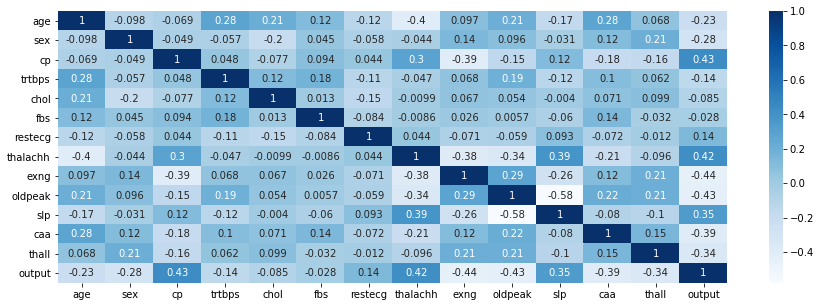

In [8]:
plt.figure(figsize=(15,5))
sns.heatmap(df_heart.corr(),annot=True,cmap='Blues')
plt.show()

###### Inference : As per the heatmap above variables cp, thalachh,exng,oldpeak,slp,caa,thall are significantly correlated with the target variable .

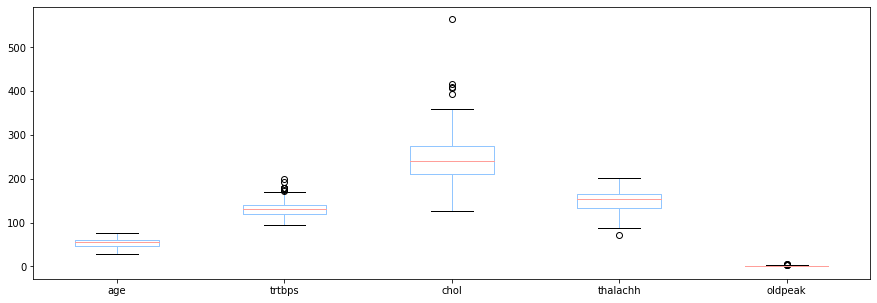

In [9]:
df_num.plot(kind='box',figsize=(15,5))
plt.show()

###### Inference : As per the boxplots above we can see that the variables 'resting blood pressure' (trtbps) & cholestoral (chol) have outliers in them. 

## Outlier Treatment :

In [10]:
# Extracting the outliers in the dataset using IQR method
Q1=df_num.quantile(0.25)
Q3=df_num.quantile(0.75)
IQR=Q3-Q1
df_heart[(((df_num)>(Q3+(1.5*IQR)))|((df_num)<(Q1-(1.5*IQR)))).any(axis=1)]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
28,65,0,2,140,417,1,0,157,0,0.8,2,1,2,1
85,67,0,2,115,564,0,0,160,0,1.6,1,0,3,1
96,62,0,0,140,394,0,0,157,0,1.2,1,0,2,1
101,59,1,3,178,270,0,0,145,0,4.2,0,0,3,1
110,64,0,0,180,325,0,1,154,1,0.0,2,0,2,1
203,68,1,2,180,274,1,0,150,1,1.6,1,0,3,0
204,62,0,0,160,164,0,0,145,0,6.2,0,3,3,0
220,63,0,0,150,407,0,0,154,0,4.0,1,3,3,0
221,55,1,0,140,217,0,1,111,1,5.6,0,0,3,0


###### Inference : Above we can see the data containing outliers which needs to be extracted since it is necessary in for training models such as KNN which is highly sensitive to outliers.

In [11]:
df_heart_new=df_heart[~(((df_num)>(Q3+(1.5*IQR)))|((df_num)<(Q1-(1.5*IQR)))).any(axis=1)]
df_heart_new.head(2)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1


In [12]:
df_heart_new.shape

(284, 14)

###### Inference : After removing outliers we get a dataset with 284 rows and 14 columns.

## Scaling numerical variables:

In [13]:
df_cat=df_heart_new.iloc[:,[1,2,5,6,8,10,11,12,13]]
df_num=df_heart_new.iloc[:,[0,3,4,7,9]]

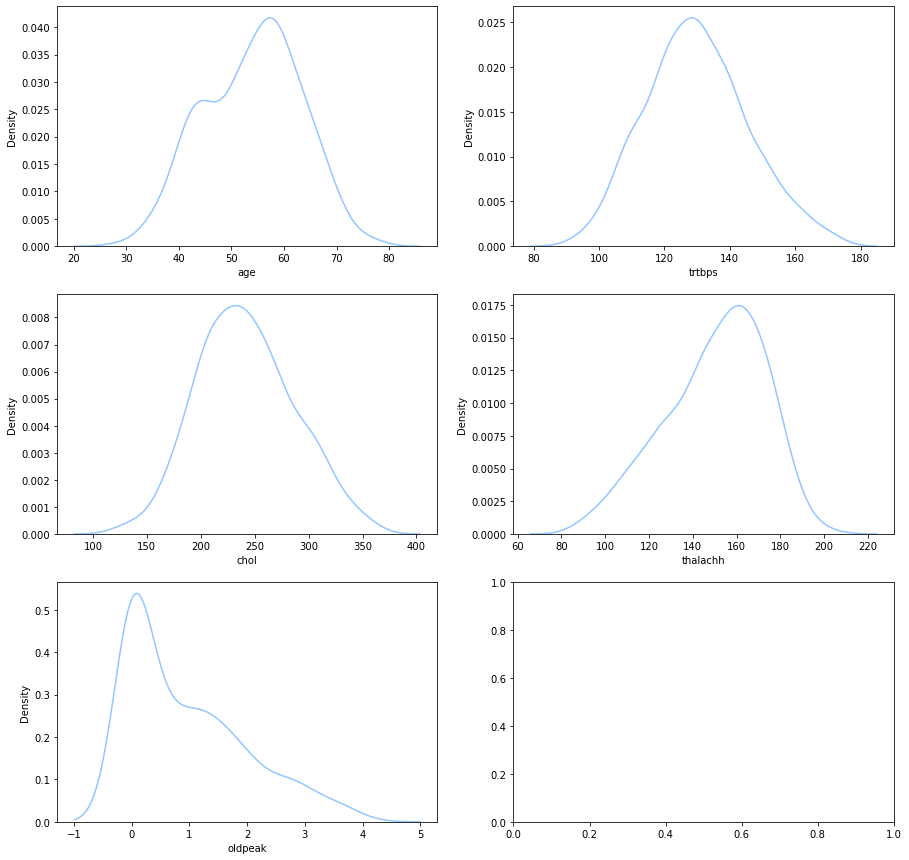

In [14]:
fig,ax=plt.subplots(3,2,figsize=(15,15))

for col,ax in zip(df_num.columns,ax.flatten()):
    x=sns.kdeplot(df_num[col],ax=ax ,palette='Pastel1')

###### Inference : As per the kdeplots above , all the variables are not normally distributed and so we apply the Normalizer function so as to normalize the data to make better interpretation.

In [15]:
sc=Normalizer()
df_scaled=pd.DataFrame(sc.fit_transform(df_num),columns=df_num.columns,index=df_num.index)
df_scaled.head(2)

,age,trtbps,chol,thalachh,oldpeak
0,0.197466,0.454485,0.730310,0.470156,0.007209
1,0.108753,0.382105,0.734817,0.549643,0.010287


## Encoding categorical variables :

In [16]:
df_cat.head(2)

,sex,cp,fbs,restecg,exng,slp,caa,thall,output
0,1,3,1,0,0,0,0,1,1
1,1,2,0,1,0,0,0,2,1


###### Inference : Since the categorical variables are in the encoded format , there is no need for further encoding.

## Distribution of Target Variable :

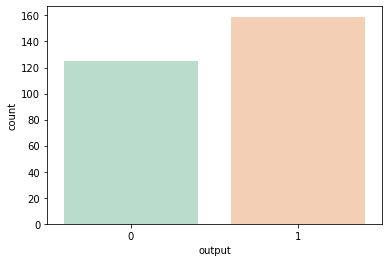

In [17]:
sns.countplot(df_heart_new['output'],palette='Pastel2')
plt.show()

In [18]:
df_heart_new['output'].value_counts()/len(df_heart_new['output'])*100

1    55.985915
0    44.014085
Name: output, dtype: float64

###### Inference: The distribution of classes within the target variable 55% and 44% which states that the difference is bearable and hence eliminates the need for balancing the variable and hence eliminating the problem of the machine learning model favousing one class over the other.

## Splitting Data into Train & Test :

In [19]:
data_heart=pd.concat([df_cat,df_scaled],axis=1)
data_heart.head(2)

,sex,cp,fbs,restecg,exng,slp,caa,thall,output,age,trtbps,chol,thalachh,oldpeak
0,1,3,1,0,0,0,0,1,1,0.197466,0.454485,0.730310,0.470156,0.007209
1,1,2,0,1,0,0,0,2,1,0.108753,0.382105,0.734817,0.549643,0.010287


In [20]:
X=data_heart.drop(columns=['output'])
y=data_heart['output']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=10)
print("X-train shape:",X_train.shape)
print("X-test shape:",X_test.shape)
print("y-train shape:",y_train.shape)
print("y-test shape:",y_test.shape)

X-train shape: (198, 13)
X-test shape: (86, 13)
y-train shape: (198,)
y-test shape: (86,)


## Defining Functions to obatin scores of Logistic Regression :

In [21]:
def conf(model,cutoff='-'):
    if model==log_reg:
        y_pred_prob=model.predict(X_test)
        y_pred=[1 if i> cutoff else 0 for i in y_pred_prob ]
        cm=confusion_matrix(y_test,y_pred)
        sns.heatmap(cm,annot=True,fmt='d',cbar=False,cmap=ListedColormap('lightblue'),linewidths=1)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
    else:
        y_pred=model.predict(X_test)
        cm=confusion_matrix(y_test,y_pred)
        sns.heatmap(cm,annot=True,fmt='d',cbar=False,cmap=ListedColormap('lightpink'),linewidths=1)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        

Since the dataset is not highly imbalenced the model will be evaluated by accuarcy and auc score (Area under roc curve).

In [22]:
score_card=pd.DataFrame(columns=["Model Name","P-cutoff","Accuracy Score","Auc Score"])

def update_score_card(algo_name,model,cutoff='-'):
    global score_card
    
    def accuracy(model):
        if model==log_reg:
            y_pred_prob=model.predict(X_test)
            y_pred=[1 if i> cutoff else 0 for i in y_pred_prob ]
            acc_score1=accuracy_score(y_test,y_pred)
            return acc_score1
        else:
            y_pred=model.predict(X_test)
            acc_score2=accuracy_score(y_test,y_pred)
            return acc_score2
    
    def auc(model):
        if model==log_reg:
            y_pred_prob=model.predict(X_test)
            y_pred=[1 if i> cutoff else 0 for i in y_pred_prob ]
            auc_score1=roc_auc_score(y_test,y_pred_prob)
            return auc_score1
        else:
            y_pred_prob=model.predict_proba(X_test)
            auc_score2=roc_auc_score(y_test,y_pred_prob[:,1])
            return auc_score2
            
    score_card=score_card.append({"Model Name":algo_name,"P-cutoff":cutoff,"Accuracy Score":accuracy(model),
                                  "Auc Score":auc(model)},ignore_index=True)
        
    return score_card

    

## Logistic Regression  (Base Model ):

In [23]:
log_reg=Logit(y_train,X_train).fit()


Optimization terminated successfully.
         Current function value: 0.335547
         Iterations 8


In [24]:
# Predicted probablility
y_pred_prob=log_reg.predict(X_test)
y_pred_prob.head()

135    0.959091
209    0.582022
62     0.996420
155    0.874303
207    0.171253
dtype: float64

In [25]:

fpr,tpr,threshold=roc_curve(y_test,y_pred_prob)

Youden's Index is the classification cut-off probability for which the (Sensitivity + Specificity - 1) is maximized.

Youden's Index = max(Sensitivity + Specificity - 1) = max(TPR + TNR - 1) = max(TPR - FPR)

i.e. select the cut-off probability for which the (TPR - FPR) is maximum.

In [26]:
youdens_table = pd.DataFrame({'TPR': tpr,
                             'FPR': fpr,
                             'Threshold': threshold})
youdens_table['Difference']=youdens_table['TPR']-youdens_table['FPR']
youdens_table.sort_values(by=['Difference'],ascending=False)

,TPR,FPR,Threshold,Difference
10,0.818182,0.119048,0.748034,0.699134
12,0.840909,0.166667,0.631547,0.674242
14,0.863636,0.190476,0.596700,0.673160
11,0.818182,0.166667,0.670645,0.651515
13,0.840909,0.190476,0.625206,0.650433
16,0.909091,0.261905,0.432212,0.647186
15,0.863636,0.261905,0.516229,0.601732
18,0.931818,0.333333,0.343253,0.598485
8,0.681818,0.095238,0.827425,0.586580
17,0.909091,0.333333,0.366568,0.575758


###### Inference : As per the youden's index above we consider the cutoff 0.75 which corresponds to the maximum difference between TPR and FPR.

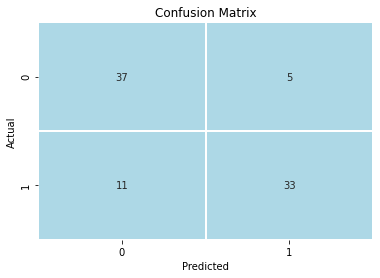

In [27]:
conf(log_reg,0.75)

In [28]:
update_score_card("Logistic Regression (Base Model)",log_reg,cutoff=0.75)

,Model Name,P-cutoff,Accuracy Score,Auc Score
0,Logistic Regression (Base Model),0.75,0.813953,0.883117


###### Inference : As per the confusion matrix , the total count of True Positives and True Negative Score is quiet high, giving us an accuracy score of 83% and Auc score of 88%.

## Logistic Regression (Feature Selection ):

In [29]:
log_reg=LogisticRegression()
rfe=RFE(estimator=log_reg,n_features_to_select=8)
rfe.fit(X_train,y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=8)

In [30]:
# Rank of each variable after RFE
sig_feat=pd.Series(rfe.ranking_,index=X_train.columns)
sig_feat

sex         1
cp          1
fbs         4
restecg     2
exng        1
slp         1
caa         1
thall       1
age         5
trtbps      3
chol        1
thalachh    1
oldpeak     6
dtype: int32

In [31]:
# Considering the features with ranking 1.
feat=sig_feat[sig_feat==1].index
feat

Index(['sex', 'cp', 'exng', 'slp', 'caa', 'thall', 'chol', 'thalachh'], dtype='object')

In [32]:
X=data_heart.loc[:,feat]
y=data_heart['output']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=10)
log_reg=Logit(y_train,X_train).fit()

Optimization terminated successfully.
         Current function value: 0.358275
         Iterations 7


In [33]:
# Predicted probablility
y_pred_prob=log_reg.predict(X_test)
fpr,tpr,threshold=roc_curve(y_test,y_pred_prob)
youdens_table = pd.DataFrame({'TPR': tpr,
                             'FPR': fpr,
                             'Threshold': threshold})
youdens_table['Difference']=youdens_table['TPR']-youdens_table['FPR']
youdens_table.sort_values(by=['Difference'],ascending=False)

,TPR,FPR,Threshold,Difference
12,0.772727,0.119048,0.709815,0.653680
14,0.795455,0.166667,0.668803,0.628788
18,0.886364,0.261905,0.496897,0.624459
13,0.772727,0.166667,0.683256,0.606061
16,0.818182,0.214286,0.628916,0.603896
15,0.795455,0.214286,0.650762,0.581169
10,0.659091,0.095238,0.812115,0.563853
17,0.818182,0.261905,0.574866,0.556277
20,0.931818,0.380952,0.384820,0.550866
11,0.659091,0.119048,0.796489,0.540043


###### Inference : As per the youden's index above we consider the cutoff 0.70 which corresponds to the maximum difference between TPR and FPR.

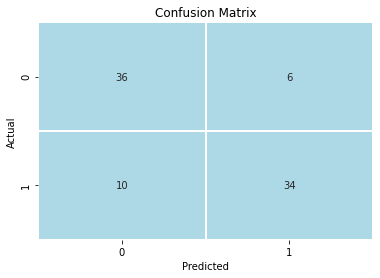

In [34]:
conf(log_reg,0.70)

In [35]:
update_score_card("Logistic Regression (Feature Selection)",log_reg,cutoff=0.70)

,Model Name,P-cutoff,Accuracy Score,Auc Score
0,Logistic Regression (Base Model),0.75,0.813953,0.883117
1,Logistic Regression (Feature Selection),0.70,0.813953,0.879329


###### Inference : After feature selection the model gives the same accuracy score. However the Auc score has reduced slightly.

## Naive Baye's Model :

In [36]:
X=data_heart.drop(columns=['output'])
y=data_heart['output']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=10)
naive=GaussianNB()
naive.fit(X_train,y_train)

GaussianNB()

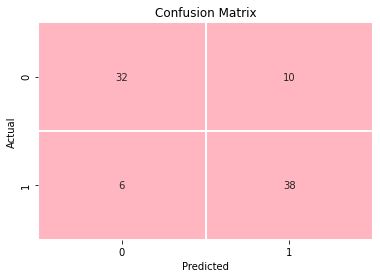

In [37]:
conf(naive)

In [38]:
update_score_card("Naive Bayes ",naive)

,Model Name,P-cutoff,Accuracy Score,Auc Score
0,Logistic Regression (Base Model),0.75,0.813953,0.883117
1,Logistic Regression (Feature Selection),0.7,0.813953,0.879329
2,Naive Bayes,-,0.813953,0.891775


###### Inference : The confusion matrix shows an increase in the total count of True Positive and True Negative and hence giving  higher  auc score from the previous model.

## KNN (Base Model) :

In [39]:
knn=KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier()

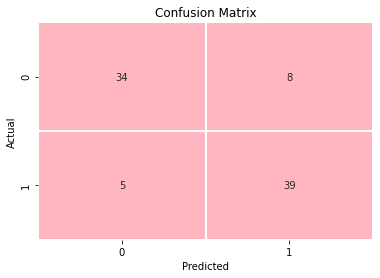

In [40]:
conf(knn)

In [41]:
update_score_card("KNN",knn)

,Model Name,P-cutoff,Accuracy Score,Auc Score
0,Logistic Regression (Base Model),0.75,0.813953,0.883117
1,Logistic Regression (Feature Selection),0.7,0.813953,0.879329
2,Naive Bayes,-,0.813953,0.891775
3,KNN,-,0.848837,0.916937


###### Inference : The KNN model gives much higher scores of accuracy 84% and auc score 91%.

##  KNN Hyper parameters tuning :

tuned_param=[{"n_neighbors":range(5,20),"metric":['minkowski','euclidean','manhattan']}]

knn1=knn=KNeighborsClassifier()

gsearch=GridSearchCV(estimator=knn1,param_grid=tuned_param)

gsearch.fit(X_train,y_train)

gsearch.best_params_

In [42]:
# Using the best parameters obtained
best={'metric': 'manhattan', 'n_neighbors': 8}
knn1=knn=KNeighborsClassifier(**best)
knn1.fit(X_train,y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=8)

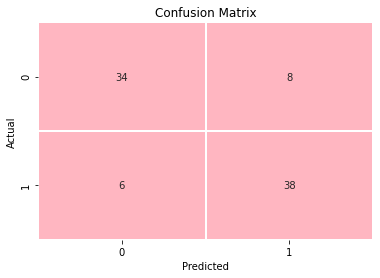

In [43]:
conf(knn1)

In [44]:
update_score_card("KNN (Grid Search)",knn1)

,Model Name,P-cutoff,Accuracy Score,Auc Score
0,Logistic Regression (Base Model),0.75,0.813953,0.883117
1,Logistic Regression (Feature Selection),0.7,0.813953,0.879329
2,Naive Bayes,-,0.813953,0.891775
3,KNN,-,0.848837,0.916937
4,KNN (Grid Search),-,0.837209,0.914502


###### After tuning the hyper parameters we can observe a slight reduction in the scores.

## Decision Tree (Base Model) :

In [45]:
tree1=DecisionTreeClassifier(random_state=10)
tree1.fit(X_train,y_train)

DecisionTreeClassifier(random_state=10)

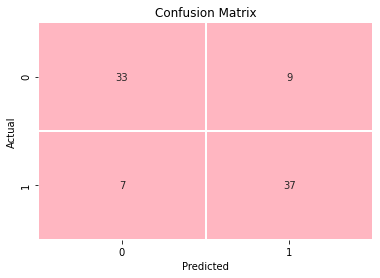

In [46]:
conf(tree1)

In [47]:
update_score_card("Decision Tree (Base Model)",tree1)

,Model Name,P-cutoff,Accuracy Score,Auc Score
0,Logistic Regression (Base Model),0.75,0.813953,0.883117
1,Logistic Regression (Feature Selection),0.7,0.813953,0.879329
2,Naive Bayes,-,0.813953,0.891775
3,KNN,-,0.848837,0.916937
4,KNN (Grid Search),-,0.837209,0.914502
5,Decision Tree (Base Model),-,0.813953,0.813312


###### Inference : We get a reduction in scores after building a decision tree model . However the accuracy and auc score are almost same i.e 81%.

## Decision Tree Hyper parameters tuning :

tuned_param=[{"criterion":['gini','entropy'],"max_depth":range(3,10),"max_features":range(2,13),"max_leaf_nodes":range(3,30)}]

tree2=DecisionTreeClassifier(random_state=10)

rsearch=RandomizedSearchCV(estimator=tree2,param_distributions=tuned_param,cv=3)

rsearch.fit(X_train,y_train)

rsearch.best_params_

In [48]:
best={'max_leaf_nodes': 16,
 'max_features': 3,
 'max_depth': 4,
 'criterion': 'entropy'}
tree2=DecisionTreeClassifier(random_state=10,**best)
tree2.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=3,
                       max_leaf_nodes=16, random_state=10)

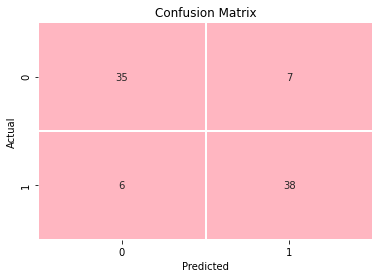

In [49]:
conf(tree2)

In [50]:
update_score_card("Decision Tree (Randomised Search)",tree2)

,Model Name,P-cutoff,Accuracy Score,Auc Score
0,Logistic Regression (Base Model),0.75,0.813953,0.883117
1,Logistic Regression (Feature Selection),0.7,0.813953,0.879329
2,Naive Bayes,-,0.813953,0.891775
3,KNN,-,0.848837,0.916937
4,KNN (Grid Search),-,0.837209,0.914502
5,Decision Tree (Base Model),-,0.813953,0.813312
6,Decision Tree (Randomised Search),-,0.848837,0.860390


###### Inference : After tuning the hyperparameters of the decision tree we get an increase in scores from the previous model.

## Random Forest (Base Model) :

In [53]:
rf1=RandomForestClassifier(random_state=10)
rf1.fit(X_train,y_train)

RandomForestClassifier(random_state=10)

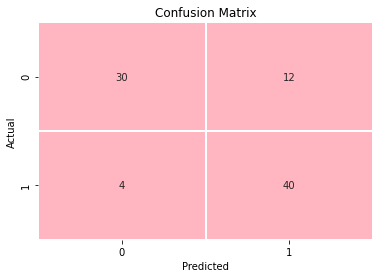

In [55]:
conf(rf1)

In [54]:
update_score_card("Random Forest (Base Model)",rf1)

,Model Name,P-cutoff,Accuracy Score,Auc Score
0,Logistic Regression (Base Model),0.75,0.813953,0.883117
1,Logistic Regression (Feature Selection),0.7,0.813953,0.879329
2,Naive Bayes,-,0.813953,0.891775
3,KNN,-,0.848837,0.916937
4,KNN (Grid Search),-,0.837209,0.914502
5,Decision Tree (Base Model),-,0.813953,0.813312
6,Decision Tree (Randomised Search),-,0.848837,0.860390
7,Random Forest (Base Model),-,0.813953,0.896374


###### Inference : We observe a reduction in accuracy but an increase in auc score.

## Random Forest Hyper parameters tuning :

tuned_param=[{"n_estimators":range(100,200),"criterion":

['gini','entropy'],"max_depth":range(3,10),"max_features":range(2,13),"max_leaf_nodes":range(3,30)}]

rf2=RandomForestClassifier(random_state=10)

rsearch=RandomizedSearchCV(estimator=rf2,param_distributions=tuned_param,cv=3)

rsearch.fit(X_train,y_train)

rsearch.best_params_

In [58]:
best={'n_estimators': 170,
 'max_leaf_nodes': 5,
 'max_features': 10,
 'max_depth': 7,
 'criterion': 'gini'}

rf2=RandomForestClassifier(random_state=10,**best)
rf2.fit(X_train,y_train)

RandomForestClassifier(max_depth=7, max_features=10, max_leaf_nodes=5,
                       n_estimators=170, random_state=10)

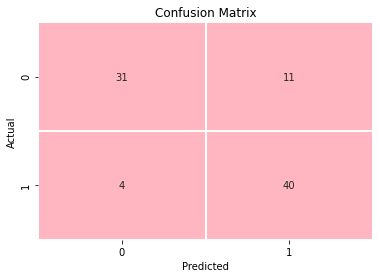

In [59]:
conf(rf2)

In [60]:
update_score_card("Random Forest (Randomised Search)",rf2)

,Model Name,P-cutoff,Accuracy Score,Auc Score
0,Logistic Regression (Base Model),0.75,0.813953,0.883117
1,Logistic Regression (Feature Selection),0.7,0.813953,0.879329
2,Naive Bayes,-,0.813953,0.891775
3,KNN,-,0.848837,0.916937
4,KNN (Grid Search),-,0.837209,0.914502
5,Decision Tree (Base Model),-,0.813953,0.813312
6,Decision Tree (Randomised Search),-,0.848837,0.860390
7,Random Forest (Base Model),-,0.813953,0.896374
8,Random Forest (Randomised Search),-,0.825581,0.917208


###### Inference : After tuning the hyper parameters we see an increase in the scores.

## Adaboost (Base Model) :

In [63]:
adaboost1=AdaBoostClassifier(random_state=10)
adaboost1.fit(X_train,y_train)

AdaBoostClassifier(random_state=10)

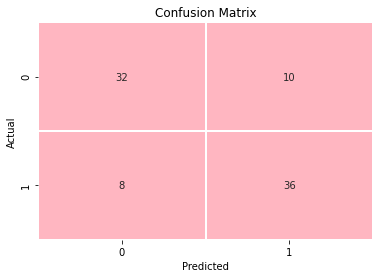

In [64]:
conf(adaboost1)

In [65]:
update_score_card("Adaboost (Base Model)",adaboost1)

,Model Name,P-cutoff,Accuracy Score,Auc Score
0,Logistic Regression (Base Model),0.75,0.813953,0.883117
1,Logistic Regression (Feature Selection),0.7,0.813953,0.879329
2,Naive Bayes,-,0.813953,0.891775
3,KNN,-,0.848837,0.916937
4,KNN (Grid Search),-,0.837209,0.914502
5,Decision Tree (Base Model),-,0.813953,0.813312
6,Decision Tree (Randomised Search),-,0.848837,0.860390
7,Random Forest (Base Model),-,0.813953,0.896374
8,Random Forest (Randomised Search),-,0.825581,0.917208
9,Adaboost (Base Model),-,0.790698,0.845238


######  Inference :Adaboost model has gives lower scores as compared to the previous models.

## Adaboost Hyper parameters tuning :

tuned_param=[{"n_estimators":range(50,100),"learning_rate":[.001,.002,.004,.004,.006,.008,0.1,0.2,0.4,0.6,0.8,1,2]}]

adaboost2=AdaBoostClassifier(random_state=10)

rsearch=RandomizedSearchCV(estimator=adaboost2,param_distributions=tuned_param,cv=3)

rsearch.fit(X_train,y_train)

rsearch.best_params_

In [71]:
best={'n_estimators': 63, 'learning_rate': 0.008}
adaboost2=AdaBoostClassifier(random_state=10,**best)
adaboost2.fit(X_train,y_train)

AdaBoostClassifier(learning_rate=0.008, n_estimators=63, random_state=10)

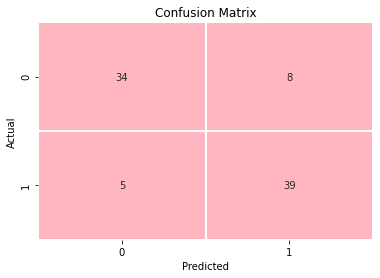

In [72]:
conf(adaboost2)

In [73]:
update_score_card("Adaboost (Randomised Search)",adaboost2)

,Model Name,P-cutoff,Accuracy Score,Auc Score
0,Logistic Regression (Base Model),0.75,0.813953,0.883117
1,Logistic Regression (Feature Selection),0.7,0.813953,0.879329
2,Naive Bayes,-,0.813953,0.891775
3,KNN,-,0.848837,0.916937
4,KNN (Grid Search),-,0.837209,0.914502
5,Decision Tree (Base Model),-,0.813953,0.813312
6,Decision Tree (Randomised Search),-,0.848837,0.860390
7,Random Forest (Base Model),-,0.813953,0.896374
8,Random Forest (Randomised Search),-,0.825581,0.917208
9,Adaboost (Base Model),-,0.790698,0.845238


###### Inference :After tuning the hyper parameters we see an increase in the scores.

## XGBoost (Base Model) :

In [75]:
xgb1=XGBClassifier(random_state=10)
xgb1.fit(X_train,y_train)

[13:28:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

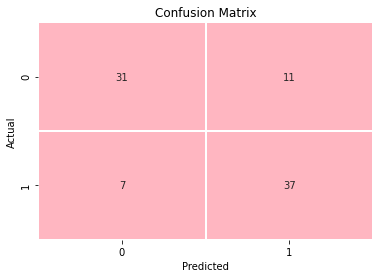

In [76]:
conf(xgb1)

In [77]:
update_score_card("XGBoost (Base Model)",xgb1)

,Model Name,P-cutoff,Accuracy Score,Auc Score
0,Logistic Regression (Base Model),0.75,0.813953,0.883117
1,Logistic Regression (Feature Selection),0.7,0.813953,0.879329
2,Naive Bayes,-,0.813953,0.891775
3,KNN,-,0.848837,0.916937
4,KNN (Grid Search),-,0.837209,0.914502
5,Decision Tree (Base Model),-,0.813953,0.813312
6,Decision Tree (Randomised Search),-,0.848837,0.860390
7,Random Forest (Base Model),-,0.813953,0.896374
8,Random Forest (Randomised Search),-,0.825581,0.917208
9,Adaboost (Base Model),-,0.790698,0.845238


###### Inference :XGboost model has gives lower scores as compared to the previous models.

## XGboost Hyper parameters tuning :

tuned_param=[{"n_estimators":range(100,200),"max_depth":range(3,10),"learning_rate":

[.001,.002,.004,.004,.006,.008,0.1,0.2,0.4,0.6,0.8,1,2],"gamma":[0.1,0.3,0.5,0.7,0.9,1,2,3,4,5,6,7,8,9,10]}]

xgb2=XGBClassifier(random_state=10)

rsearch=RandomizedSearchCV(estimator=xgb2,param_distributions=tuned_param,cv=3)

rsearch.fit(X_train,y_train)

rsearch.best_params_

In [81]:
best={'n_estimators': 173, 'max_depth': 6, 'learning_rate': 0.004, 'gamma': 9}
xgb2=xgb2=XGBClassifier(random_state=10,**best)
xgb2.fit(X_train,y_train)

[13:35:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=9, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.004, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=173, n_jobs=8, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

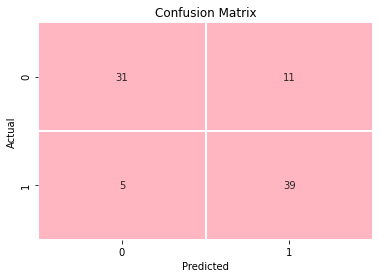

In [82]:
conf(xgb2)

In [83]:
update_score_card("XGboost (Randomised Search)",xgb2)

,Model Name,P-cutoff,Accuracy Score,Auc Score
0,Logistic Regression (Base Model),0.75,0.813953,0.883117
1,Logistic Regression (Feature Selection),0.7,0.813953,0.879329
2,Naive Bayes,-,0.813953,0.891775
3,KNN,-,0.848837,0.916937
4,KNN (Grid Search),-,0.837209,0.914502
5,Decision Tree (Base Model),-,0.813953,0.813312
6,Decision Tree (Randomised Search),-,0.848837,0.860390
7,Random Forest (Base Model),-,0.813953,0.896374
8,Random Forest (Randomised Search),-,0.825581,0.917208
9,Adaboost (Base Model),-,0.790698,0.845238


###### Inference : After tuning the hyper parameters we see an increase in the scores.

## Stacking Classifiers :

In [92]:
base_estimators=[("Naive Bayes",GaussianNB()),("KNN",KNeighborsClassifier(metric='manhattan',n_neighbors = 8)),
                ("Random Forest",RandomForestClassifier(n_estimators= 170,
 max_leaf_nodes= 5,
 max_features=10,
 max_depth=7,
 criterion= 'gini'))]

stack_model=StackingClassifier(estimators=base_estimators,final_estimator=xgb2,cv=3)
stack_model.fit(X_train,y_train)

[13:47:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


StackingClassifier(cv=3,
                   estimators=[('Naive Bayes', GaussianNB()),
                               ('KNN',
                                KNeighborsClassifier(metric='manhattan',
                                                     n_neighbors=8)),
                               ('Random Forest',
                                RandomForestClassifier(max_depth=7,
                                                       max_features=10,
                                                       max_leaf_nodes=5,
                                                       n_estimators=170))],
                   final_estimator=XGBClassifier(base_score=0.5,
                                                 booster='gbtree',
                                                 colsample_bylevel=1,
                                                 colsample_bynode=1,
                                                 colsample_bytree=1, gamma=9,
                                            

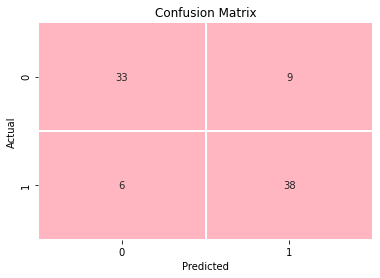

In [93]:
conf(stack_model)

In [94]:
update_score_card("Stacking Model",stack_model)

,Model Name,P-cutoff,Accuracy Score,Auc Score
0,Logistic Regression (Base Model),0.75,0.813953,0.883117
1,Logistic Regression (Feature Selection),0.7,0.813953,0.879329
2,Naive Bayes,-,0.813953,0.891775
3,KNN,-,0.848837,0.916937
4,KNN (Grid Search),-,0.837209,0.914502
5,Decision Tree (Base Model),-,0.813953,0.813312
6,Decision Tree (Randomised Search),-,0.848837,0.860390
7,Random Forest (Base Model),-,0.813953,0.896374
8,Random Forest (Randomised Search),-,0.825581,0.917208
9,Adaboost (Base Model),-,0.790698,0.845238


###### Inference : After Stacking multiple classifiers we  see an increase in the accuracy score but a slight decrease in auc score.

In [104]:
score_card.style.highlight_max(['Auc Score'],color='skyblue')

,Model Name,P-cutoff,Accuracy Score,Auc Score
0,Logistic Regression (Base Model),0.750000,0.813953,0.883117
1,Logistic Regression (Feature Selection),0.700000,0.813953,0.879329
2,Naive Bayes,-,0.813953,0.891775
3,KNN,-,0.848837,0.916937
4,KNN (Grid Search),-,0.837209,0.914502
5,Decision Tree (Base Model),-,0.813953,0.813312
6,Decision Tree (Randomised Search),-,0.848837,0.860390
7,Random Forest (Base Model),-,0.813953,0.896374
8,Random Forest (Randomised Search),-,0.825581,0.917208
9,Adaboost (Base Model),-,0.790698,0.845238


###### Inference : The model giving us the highest AUC score is Random Forest (Randomised Search) of 91% . Further cross validating this score for conformation.

## Cross Validating the AUC score :

In [132]:
scores=cross_val_score(estimator=rf2,X=X_train,y=y_train,scoring='roc_auc',cv=10)

In [131]:
print("Minimum score:",round(scores.min(),4))
print("Maximum score:",round(scores.max(),4))
print("Average score:",round(scores.mean(),4))

Minimum score: 0.7576
Maximum score: 1.0
Average score: 0.8819


###### Inference : The average score obtained after cross_validation is 86% .This means the Random Forest (Randomised Search) model is overfitted.

### Looking at the Random Forest (Base Model) giving an AUC score of 89% 

In [133]:
scores=cross_val_score(estimator=rf1,X=X_train,y=y_train,scoring='roc_auc',cv=10)

In [134]:
print("Minimum score:",round(scores.min(),4))
print("Maximum score:",round(scores.max(),4))
print("Average score:",round(scores.mean(),4))

Minimum score: 0.7576
Maximum score: 1.0
Average score: 0.8819


###### Inference : After cross validating the auc scores of the model  Random Forest (Base Model) we get an average score of 88% .This means the effect of over-fitting in this model is much lower than the previous model.

## Conclusion :

In [135]:
score_card

,Model Name,P-cutoff,Accuracy Score,Auc Score
0,Logistic Regression (Base Model),0.75,0.813953,0.883117
1,Logistic Regression (Feature Selection),0.7,0.813953,0.879329
2,Naive Bayes,-,0.813953,0.891775
3,KNN,-,0.848837,0.916937
4,KNN (Grid Search),-,0.837209,0.914502
5,Decision Tree (Base Model),-,0.813953,0.813312
6,Decision Tree (Randomised Search),-,0.848837,0.860390
7,Random Forest (Base Model),-,0.813953,0.896374
8,Random Forest (Randomised Search),-,0.825581,0.917208
9,Adaboost (Base Model),-,0.790698,0.845238


##### * The model Random Forest (Base Model) is considered best fitted since it gives an AUC of 89 % and an accuracy score of 81% .

##### * The situation of over-fitting is doesn't arise in this model.

##### * This also means the model has a comparitively lower variance and lower bias as compared to other models.